## Credentials of the Data Asset

In [1]:
credentials_6 = {
    'IAM_SERVICE_ID': 'iam-ServiceId-0c9024d2-deba-4c58-9848-94ad54f41312',
    'IBM_API_KEY_ID': 'ZCw4mPNPhOmn2GpUI0FD59WfQuyCFwQMmusbgjVSpTeF',
    'ENDPOINT': 'https://s3-api.us-geo.objectstorage.service.networklayer.com',
    'IBM_AUTH_ENDPOINT': 'https://iam.cloud.ibm.com/oidc/token',
    'BUCKET': 'agcwatsonstudioproject-donotdelete-pr-oahdwlxwjnxxjn',
    'FILE': 'new_520_questions'
}


# WATSON DISCOVERY PIPELINE

## Entity Retrieval Class

In [2]:
import json
from ibm_botocore.client import Config
import ibm_boto3
from collections import defaultdict


class EntityRetrieval(object):

    def __init__(self,credentials):
        self.credentials = credentials
        self.filename = credentials['FILE']
        self.local_file_name = credentials['FILE']
        self.key = credentials['FILE']
        self.local_name = credentials['local_name']

    def upload_file_cos(self):
        cos = ibm_boto3.client(service_name='s3',
                               ibm_api_key_id=self.credentials['IBM_API_KEY_ID'],
                               ibm_service_instance_id=self.credentials['IAM_SERVICE_ID'],
                               ibm_auth_endpoint=self.credentials['IBM_AUTH_ENDPOINT'],
                               config=Config(signature_version='oauth'),
                               endpoint_url=self.credentials['ENDPOINT'])
        try:
            res = cos.upload_file(Filename=self.local_name, Bucket=self.credentials['BUCKET'], Key=self.local_name)
        except Exception as e:
            print(Exception, e)
        else:
            print('File Uploaded to Cloud Object Storage')

    def download_file_cos(self):
        cos = ibm_boto3.client(service_name='s3',
                               ibm_api_key_id=self.credentials['IBM_API_KEY_ID'],
                               ibm_service_instance_id=self.credentials['IAM_SERVICE_ID'],
                               ibm_auth_endpoint=self.credentials['IBM_AUTH_ENDPOINT'],
                               config=Config(signature_version='oauth'),
                               endpoint_url=self.credentials['ENDPOINT'])
        try:
            res = cos.download_file(Bucket=self.credentials['BUCKET'], Key=self.key, Filename=self.local_file_name)
        except Exception as e:
            print(Exception, e)
        else:
            print('File Downloaded from Cloud Object Storage')

    def clean_json_encoding(self):
        #Download the data
        self.download_file_cos()
        
        with open(self.local_file_name, 'r') as f:
            s = f.read()
            s = s.replace('\t', '')
            s = s.replace('\n', '')
            s = s.replace(',}', '}')
            s = s.replace(',]', ']')
            data = json.loads(s)
            return data


    def retreive_entity(self,response=[],nlu=False):
        entity_raw_list = []
        if nlu:
            print("Executing from Response")
            results = response
            for i,each in enumerate(results):
                entity_raw_list.append(results[i]['entities'])
            
        else:
            data = self.clean_json_encoding()
            # print(data.keys())
            for key, value in data.items():
                if key == "results":
                    results = data[key]
                    for i,each in enumerate(results):
                        entity_raw_list.append(results[i]['enriched_text']['entities'])
            
 
        return entity_raw_list


    def get_entity_dict(self,response=[],nlu=False):
        raw_list = self.retreive_entity(response,nlu)
        result_dict = {}
        for i, element in enumerate(raw_list):
            sub_dict= defaultdict(list)
            for j, each in enumerate(element):
                sub_dict.setdefault(each['type'], []).append(each['text'])
            result_dict[i] = sub_dict

        return result_dict


In [ ]:
import os
from multiprocessing import Process
from multiprocessing import Pool, Queue
from time import sleep

class EntityExtractorNLU(EntityRetrieval):
    
    q = Queue()
    
    def __init__(self, credentials,apikey,modelid,url):
        super().__init__(credentials)
        self.apikey = apikey
        self.modelid = modelid
        self.url = url
        
    def read_from_zip(self):
        with ZipFile(self.filename, 'r') as file:
            file.extractall()
            print('Done Extracting all the files')
        os.remove(self.filename)     
    
    def get_entity_response_nlu(self,data):
        authenticator = IAMAuthenticator(self.apikey)
        natural_language_understanding = NaturalLanguageUnderstandingV1(version='2019-07-12',
                                                                    authenticator=authenticator)
        natural_language_understanding.set_service_url(self.url)
        response = natural_language_understanding.analyze(text=data, 
                                                          features=Features(entities=EntitiesOptions(model=self.modelid))).get_result()
        return response
    
    
        
    def get_entity_response_nlu_parallel(self,file,q):
        if not file.startswith("._"):
            with open(file,'r')as f:
                data = f.read()
        
        authenticator = IAMAuthenticator(self.apikey)
        natural_language_understanding = NaturalLanguageUnderstandingV1(version='2019-07-12',
                                                                    authenticator=authenticator)
        natural_language_understanding.set_service_url(self.url)
        response = natural_language_understanding.analyze(text=data, 
                                                          features=Features(entities=EntitiesOptions(model=self.modelid))).get_result()
        q.put(result_dict)        
        q.put("/t")
    
    
    
    def parallel_read(self):
        processes = []
        responses =[]
        for root,dirs,files in os.walk("."):
            for file in files:
                print("Process Started")
                p = Process(target=get_entity_response_nlu_parallel, args=(file,q))
                processes.append(p)
                p.start()
        for t in processes:
            t.join()
    
    
    def sequential_read(self):
        responses = []
        #self.read_from_zip()
        for root,dirs,files in os.walk("."):
            for file in files:
                try:
                    if not file.startswith("._"):
                        with open(file,'r')as f:
                            data = f.read()
                            #data = data.encode('utf-8').strip()
                            responses.append(self.get_entity_response_nlu(data))
                except Exception as e:
                    print("Inner Exception")
                    #print(file,e)
        return responses

## Supply the CREDENTIALS of the file to be run.
##                                    &
## Supply the Filename of the CSV file to be added as data asset

In [3]:
# import pandas as pd
# credentials_6['local_name'] ='520_refined.csv'
# entity_extractor = EntityRetrieval(credentials_6)


## Analyse the Format as Dataframe

In [4]:
# result_dict = entity_extractor.get_entity_dict()
# df = pd.DataFrame.from_dict(result_dict)
# df= df.transpose()
# columns = list(df.columns)
# columns = [each.upper() for each in columns]
# df.columns = columns
# df.head()

## Save the file in Cloud Object Storage

In [5]:
# df.to_csv("520_refined.csv",index=False)
# entity_extractor.upload_file_cos()

# NLU PIPELINE

In [6]:
!pip install --user ibm_watson

     |████████████████████████████████| 389kB 9.8MB/s eta 0:00:01
     |████████████████████████████████| 204kB 31.5MB/s eta 0:00:01
  Stored in directory: /home/dsxuser/.cache/pip/wheels/6e/14/69/dbbd573a3bab3bf64984572284f13f174f430038308abdd73c
  Stored in directory: /home/dsxuser/.cache/pip/wheels/34/6e/58/589e0f841c2fae9dad99630d78ddc7a60c5c7663a16a39cdbb
Successfully built ibm-watson ibm-cloud-sdk-core
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [7]:
import json
import csv
import psycopg2
from zipfile import ZipFile
from ibm_watson import NaturalLanguageUnderstandingV1
from ibm_cloud_sdk_core.authenticators import IAMAuthenticator
from ibm_watson.natural_language_understanding_v1 import Features, EntitiesOptions

# extract all entities
import os, pandas as pd
#import librosa
import codecs
from pandas.io.json import json_normalize
import json
import csv
import psycopg2
from ibm_watson import NaturalLanguageUnderstandingV1
from ibm_cloud_sdk_core.authenticators import IAMAuthenticator
from ibm_watson.natural_language_understanding_v1 import Features, EntitiesOptions

In [8]:
# The code was removed by Watson Studio for sharing.

In [9]:
import os
from multiprocessing import Process
from multiprocessing import Pool, Queue
from time import sleep

class EntityExtractorNLU(EntityRetrieval):
    
    q = Queue()
    
    def __init__(self, credentials,apikey,modelid,url):
        super().__init__(credentials)
        self.apikey = apikey
        self.modelid = modelid
        self.url = url
        
    def read_from_zip(self):
        with ZipFile(self.filename, 'r') as file:
            file.extractall()
            print('Done Extracting all the files')
        os.remove(self.filename)     
    
    def get_entity_response_nlu(self,data):
        authenticator = IAMAuthenticator(self.apikey)
        natural_language_understanding = NaturalLanguageUnderstandingV1(version='2019-07-12',
                                                                    authenticator=authenticator)
        natural_language_understanding.set_service_url(self.url)
        response = natural_language_understanding.analyze(text=data, 
                                                          features=Features(entities=EntitiesOptions(model=self.modelid))).get_result()
        return response
    
    
        
    def get_entity_response_nlu_parallel(self,file,q):
        if not file.startswith("._"):
            with open(file,'r')as f:
                data = f.read()
        
        authenticator = IAMAuthenticator(self.apikey)
        natural_language_understanding = NaturalLanguageUnderstandingV1(version='2019-07-12',
                                                                    authenticator=authenticator)
        natural_language_understanding.set_service_url(self.url)
        response = natural_language_understanding.analyze(text=data, 
                                                          features=Features(entities=EntitiesOptions(model=self.modelid))).get_result()
        q.put(result_dict)        
        q.put("/t")
    
    
    
    def parallel_read(self):
        processes = []
        responses =[]
        for root,dirs,files in os.walk("."):
            for file in files:
                print("Process Started")
                p = Process(target=get_entity_response_nlu_parallel, args=(file,q))
                processes.append(p)
                p.start()
        for t in processes:
            t.join()
    
    
    def sequential_read(self):
        responses = []
        #self.read_from_zip()
        for root,dirs,files in os.walk("."):
            for file in files:
                try:
                    if not file.startswith("._"):
                        with open(file,'r')as f:
                            data = f.read()
                            #data = data.encode('utf-8').strip()
                            responses.append(self.get_entity_response_nlu(data))
                except Exception as e:
                    print("Inner Exception")
                    #print(file,e)
        return responses
    
    
        
 
    
    

In [10]:
!rm -rf *.txt new_520_questions __MACOSX *.zip *.csv
!ls

In [11]:
#apikey="KsR5UQVyfNVoMv_L22Eb5wIN1uC_skrlnS1g-FZFrHah"
#url="https://api.us-south.natural-language-understanding.watson.cloud.ibm.com/instances/102041c7-61e3-4db8-95f7-58e897a6fb90"
#modelid="502a373e-279a-44fa-978b-d2a15d8e3033"
#modelid="bb5c168e-5419-4a9d-a21d-2cd6f09d02d6"

## Rule Based Model

cred_dict = {'Rule':{'apikey':"3Btf9d5pEK_U_IWJHPY0i_y-tfG0wdDqi1_Kus_xaLMp","modelid":"20:e8603681-0fdf-41d5-962b-fcfbbf9a78ce"
                   ,"url":"https://api.us-south.natural-language-understanding.watson.cloud.ibm.com/instances/39dc602e-52ac-4f19-8961-1018efc15855"},
           'ML':  {'apikey':"KsR5UQVyfNVoMv_L22Eb5wIN1uC_skrlnS1g-FZFrHah","modelid":"891c2c72-45a1-4c81-bb27-ed746fe4cd6f"
                   ,"url":"https://api.us-south.natural-language-understanding.watson.cloud.ibm.com/instances/102041c7-61e3-4db8-95f7-58e897a6fb90"}
          }


cred_dict_1 = {'Rule':{'apikey':"zntJ69bXiZF9luI20hqdIbiLVlLQaeNdE1icYOlfwUL4","modelid":"20:9c45f83c-7c13-439c-97ce-474eebf3c45b"
                   ,"url":"https://api.us-south.natural-language-understanding.watson.cloud.ibm.com/instances/28842d9d-1ed1-48cb-af83-d64c054968fd"},
           'ML':  {'apikey':"KsR5UQVyfNVoMv_L22Eb5wIN1uC_skrlnS1g-FZFrHah","modelid":"891c2c72-45a1-4c81-bb27-ed746fe4cd6f"
                   ,"url":"https://api.us-south.natural-language-understanding.watson.cloud.ibm.com/instances/102041c7-61e3-4db8-95f7-58e897a6fb90"}
          }


### ML Model V2

# apikey="KsR5UQVyfNVoMv_L22Eb5wIN1uC_skrlnS1g-FZFrHah"
# url="https://api.us-south.natural-language-understanding.watson.cloud.ibm.com/instances/102041c7-61e3-4db8-95f7-58e897a6fb90"
# modelid="891c2c72-45a1-4c81-bb27-ed746fe4cd6f"




# #### ML Model V1
# apikey="KsR5UQVyfNVoMv_L22Eb5wIN1uC_skrlnS1g-FZFrHah"
# modelid="c93d2486-d7e8-4b41-a57f-49c611885ad4"
# url="https://api.us-south.natural-language-understanding.watson.cloud.ibm.com/instances/102041c7-61e3-4db8-95f7-58e897a6fb90"


## Driver Run for ML and Rule Based Model

In [12]:
import pandas as pd
credentials_zip['local_name'] ='520_Final_Rule_ML_v2.csv'

dataframe_list = []

for key in cred_dict.keys():
    entity_extractor_nlu = EntityExtractorNLU(credentials_zip,apikey=cred_dict_1[key]['apikey'],modelid=cred_dict_1[key]['modelid'],
                                              url=cred_dict_1[key]['url'])
    entity_extractor_nlu.download_file_cos()
    
    entity_extractor_nlu.read_from_zip()
    
    responses_list=entity_extractor_nlu.sequential_read()
    
    result_dict = entity_extractor_nlu.get_entity_dict(response=responses_list,nlu=True)
    
    df = pd.DataFrame.from_dict(result_dict)
    
    df= df.transpose()
    
    columns = list(df.columns)
    
    columns = [each.upper() for each in columns]
    
    df.columns = columns
    
    dataframe_list.append(df)
    
len(dataframe_list)
    

File Downloaded from Cloud Object Storage
Done Extracting all the files
Executing from Response
File Downloaded from Cloud Object Storage
Done Extracting all the files
Executing from Response


2

In [13]:
rule_df = dataframe_list[0]
ml_df = dataframe_list[1]
rule_df.head()

,AGEOFACCUSED,CASENUMBER,CHARGENUMBER,DATEOFBIRTH,DATEOFOFFENCE,DRUGTYPE1,DRUGWEIGHT1,GENDEROFACCUSED,GENERALTYPEOFOFFENCE,HSALABNUMBER1,IDENTITYNUMBER,NATIONALITY,OFFENCECONNECTOR,RELATEDDRUGTYPE,REPORTNUMBER
0,[32 YEARS OLD],[AG-123888-2019],[DAC-921632-2019],[: 03/08/1987],"[on 21 Jan 2019, on 21 January 2019]",NaN,NaN,[MALE],[Drugs],NaN,[S9898491J],"[SINGAPOREAN, Singapore, SINGAPORE]","[punished under, punishable under]",NaN,[G/20181101/2149]
1,"[10 years, 32 YEARS OLD]",[AG-123888-2019],[DAC-921628-2019],[: 03/08/1987],"[on 01 October 2015, on 25 January 2019, on 25...",[Methamphetamine],"[16.8 grams, 24.99 grams]",[MALE],"[drug, Drug, Misuse of Drugs Act]","[ID-1932-00193-012, ID-1932-00193-014, ID-1932...",[S9898491J],"[SINGAPOREAN, SINGAPORE, Singapore]","[punishment under, punished under]",[crystalline substance],[A/20190125/2086]
2,"[10 years, 21 years old]",[AG-123412-2019],[DAC-923884-2019],[: 17/03/1998],[on 14 February 2019],[MDMA],NaN,"[male, MALE]","[Drugs, Drug, Misuse of Drugs Act]",[ID-1932-0035-007],"[G9898513L, S9898140J]","[MALAYSIA, Singapore, SINGAPORE]","[read with, punishable under]",NaN,[A/20190215/2006]
3,[20 years],[AG-123642-2019],[DAC-901755-2019],[: 29 November 1969],[on 4 September 2018],[Diamorphine],"[451.3 grams, 5.53 grams]",[M],"[drug, Misuse of Drugs Act]",[HSA Report: ID-1832-02118],"[S9898750B, S9898456H]",[Singapore],"[read with, punishable under, read with]","[powdery, substance, granular]",[Report No: A/20180905/2003]
4,"[49 Years Old, 10 years]",[AG-123642-2019],[DAC-909461-2019],[: 29 November 1969],NaN,[Methamphetamine],"[4.94 grams, 7.27 grams]",[Male],"[Drugs, Drug, Misuse of Drugs Act]",[ID-1832-02119-011],[S9898750B],"[Singapore, SINGAPORE, Singaporean]",[punishable under],[crystalline substance],[A/20180905/2003]


In [14]:
rule_df.shape

(520, 15)

In [15]:
ml_df.shape

(520, 17)

### Read File from COS

In [16]:
# The code was removed by Watson Studio for sharing.

In [17]:
# body = client_6a1dd7bf12d24938b55e69a36c33dec7.get_object(Bucket='agcwatsonstudioproject-donotdelete-pr-oahdwlxwjnxxjn',Key='Machine_Learning_Model_520_text_nlu.csv')['Body']
# # add missing __iter__ method, so pandas accepts body as file-like object
# if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

# ml_df = pd.read_csv(body)

ml_df_new = ml_df.copy()
rule_df_new = rule_df.copy()
ml_df.shape,rule_df.shape

((520, 17), (520, 15))

In [18]:
import numpy as np
len(np.unique(ml_df_new['CASENUMBER'])),len(np.unique(rule_df_new['CASENUMBER']))

(133, 100)

In [19]:
ml_df_new['CASENUMBER']= ml_df_new['CASENUMBER'].apply(lambda x: sorted(x)[0])
rule_df_new['CASENUMBER']= rule_df_new['CASENUMBER'].apply(lambda x: sorted(x)[0])

# ml_df_new['CASENUMBER']= ml_df_new['CASENUMBER'].apply(lambda x:x[0])
#rule_df_new['CASENUMBER']= rule_df_new['CASENUMBER'].apply(lambda x:x[0])
#ml_df = ml_df.sort_values(by='CASENUMBER')
len(np.unique(ml_df_new['CASENUMBER'])),len(np.unique(rule_df_new['CASENUMBER']))
#set(np.unique(ml_df_new['CASENUMBER'])) - set(np.unique(rule_df_new['CASENUMBER']))

(98, 98)

In [20]:
ml_cols = ['CASENUMBER','FIRSTPARTOFOFFENCE','OFFENCECONNECTOR','SECONDPARTOFOFFENCE']
diff_cols = ['FIRSTPARTOFOFFENCE','OFFENCECONNECTOR','SECONDPARTOFOFFENCE']
ml_residual = ml_df_new[ml_cols]

#ml_df_new['CASENUMBER']= ml_df_new['CASENUMBER'].apply(lambda x: x[0])
# ml_df_new = ml_df_new.apply(lambda x: tuple(set(x)))
# ml_df_new = ml_df_new.apply(lambda x: x[0] if len(x) ==1 else x)
ml_residual.shape,rule_df_new.shape

((520, 4), (520, 15))

In [21]:
# test= pd.concat([ml_df_new['CASENUMBER'].value_counts(),rule_df_new['CASENUMBER'].value_counts()],axis=1,names=['ML_CASE','RULE_CASE'])
# test.columns = ['ML_CASE','RULE_CASE']
# test['ML_CASE'].astype(float)
# test['RULE_CASE'].astype(float)
# test['DIFF'] = test['RULE_CASE'].equals(test['ML_CASE'])
# test['DIFF'].value_counts()

In [22]:
ml_df_new.head()

,AGEOFACCUSED,CASENUMBER,CHARGENUMBER,DATEOFBIRTH,DATEOFOFFENCE,DRUGTYPE1,DRUGWEIGHT1,FIRSTPARTOFOFFENCE,GENDEROFACCUSED,GENERALTYPEOFOFFENCE,HSALABNUMBER1,IDENTITYNUMBER,NATIONALITY,OFFENCECONNECTOR,RELATEDDRUGTYPE,REPORTNUMBER,SECONDPARTOFOFFENCE
0,[32 YEARS OLD],AG-123888-2019,"[DAC-921632-2019, DAC-921632-2019]",[: 03/08/1987],"[on 21 Jan 2019, on 21 January 2019]",NaN,NaN,[committed an\noffence under regulation 15(3)(...,[MALE],[Drugs],NaN,[S9898491J],"[Singapore, SINGAPOREAN, SINGAPORE]","[punished under, punishable under]",NaN,[G/20181101/2149],[regulation 15(6)\n(a) of the Misuse of Drugs]
1,"[32 YEARS OLD, 10 years]",AG-123888-2019,"[DAC-921628-2019, DAC-921628-2019]",[: 03/08/1987],"[on 25 Jan 2019, on 25 January 2019, on 01 Oct...","[Methamphetamine, Methamphetamine]","[16.8 grams, 24.99 grams]",[committed an offence under s 8(a) of the Misu...,[MALE],"[drug, drug, Misuse of Drugs Act, Misuse of Dr...","[ID-1932-00193-013, ID-1932-00193-014, ID-1932...",[S9898491J],"[SINGAPOREAN, SINGAPORE, Singapore]","[punished under, punished under, punishment un...",[crystalline substance],[A/20190125/2086],"[s 33(1)\nof the said Act, s 33(1) of the Misu..."
2,"[10 years, 21 years]",AG-123412-2019,[DAC-923884-2019],[: 17/03/1998],[on 14 February 2019],NaN,[2.69 gram],[committed an offence under Section 8(a)],"[male, MALE/20]","[Drug, Misuse of Drugs Act]",NaN,"[G9898513L, S9898140J]","[SINGAPORE, Singapore]","[read with, punishable under]",NaN,[A/20190215/2006],"[Section 33(1) of the said Act, Section 18(4) ..."
3,[20 years],AG-123642-2019,[DAC-901755-2019],[: 29 November 1969],[on 4 September 2018],[Diamorphine],"[451.3 grams, 5.53 grams]",[committed an \noffence under Section 5(1)(a)],[M/48],"[drug, Misuse of Drugs Act]",[ID-1832-02118-006],"[S9898456H, S9898750B]","[Singapore, Singapore]","[read with, punishable under, read with]","[powdery, granular, substance]",[Report No: A/20180905/2003],"[section 34 of the Penal Code, Section 5(..."
4,[10 years],AG-123642-2019,[DAC-909461-2019],[: 29 November 1969],[on 4 September 2018],[Methamphetamine],"[4.94 grams, 7.27 grams]",[committed an offence under Section 8(a)],[Male],"[Drug, Misuse of Drugs Act]",NaN,[S9898750B],"[SINGAPORE, Singapore, Singaporean]",[punishable under],[crystalline substance],"[A/20180905/2003, ID-1832-02119-011/003]",[Section 33(1) of the Misuse of \nDrugs Act]


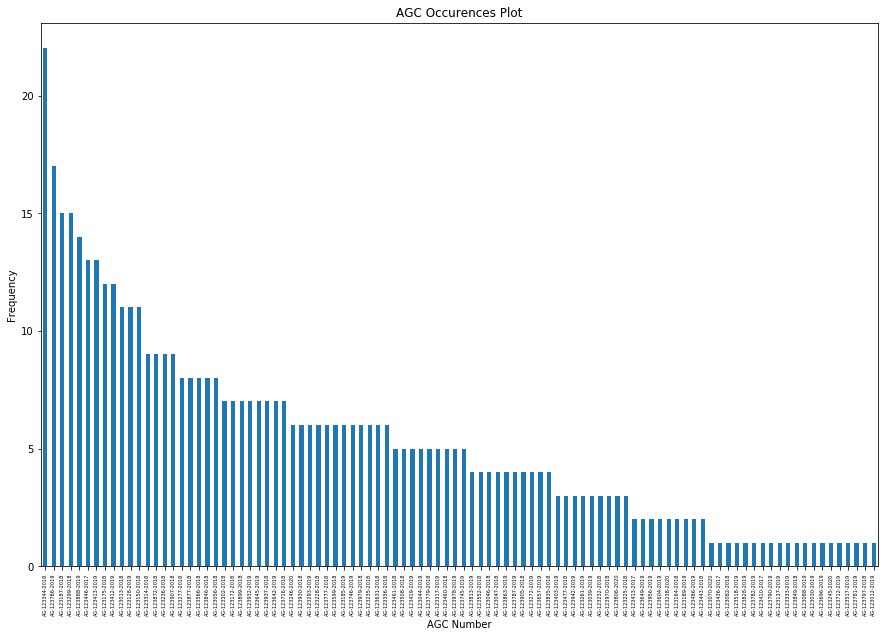

In [23]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(15,10))
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['xtick.labelsize'] = 5
plt.tight_layout()
plt.title("AGC Occurences Plot")
plt.xlabel("AGC Number")
plt.ylabel("Frequency")
ml_df_new['CASENUMBER'].value_counts().plot(kind="bar")

In [151]:
temp1 = ml_df_new.copy()
temp2 = rule_df_new.copy()
temp2 = temp2.drop(['OFFENCECONNECTOR'],axis=1)

ml_residual.columns = ["CASENUMBERS","FIRSTPARTOFOFFENCE","OFFENCECONNECTOR","SECONDPARTOFOFFENCE"]
temp4 = ml_residual.reset_index(drop=True)
temp3 = temp2.reset_index(drop=True)

#temp4 = temp3.merge(temp1,on='CASENUMBER',how='inner')
temp3 = pd.concat([ml_residual.reset_index(drop=True),temp2.reset_index(drop=True)], axis=1)

print(temp3.shape)
#print(temp4.shape)

temp3.head()
#temp4.tail()


temp4= temp3.copy()

(520, 18)


In [152]:
temp3['CASENUMBERS'] = temp3['CASENUMBERS'].apply(lambda x:x.strip().replace(" ",''))
temp3['CASENUMBER'] = temp3['CASENUMBER'].apply(lambda x:x.strip().replace(" ",''))
#temp3['DIFF'] = 
temp3['DIFF'] = temp3.apply(lambda x :True if x['CASENUMBER'] == x['CASENUMBERS'] else False, axis=1)
temp3['DIFF'].value_counts()
#temp3[temp3['DIFF']==False]

True    520
Name: DIFF, dtype: int64

In [153]:
temp3.drop(['CASENUMBER'],axis=1,inplace=True)
temp3.rename(columns = {'CASENUMBERS':'CASENUMBER'}, inplace = True)
temp3 = temp3.replace(np.nan,"")
#temp3 = temp3.replace("None",'')
#temp3.head()

In [154]:
#temp3[temp3.CHARGENUMBER=="DAC-922516-2018"]

### Cleaning Process

In [155]:
%matplotlib inline
def age_filter(age_list):
    for each in age_list:
        if "old" in each.lower().strip():
            return each
        
def gender_filter(age):
    dicts = {"M":"Male",'F':"Female"}
    age = age[0].upper()
    if age.upper() in ['MALE','FEMALE']:
        return age.capitalize()
    elif age.upper() in ['M','F']:
        return dicts[age.upper()]
    
    
def dof_filter(date):
    if len(date)>=1 and type(date)==list:
        date = date[0]
        s= date.split()
        return " ".join(s[-3:])
    else:
        return ""
    
def nationality_filter(nationality):
    dicts = {'Indian':"India",'Singaporean':"Singapore",'Malaysian':"Malaysia",'Vietnamese':"Vietanam"}
    if type(nationality) == list:
        nationality = nationality[0].capitalize()
        if nationality in dicts.keys():
            return dicts[nationality]
        else:
            return nationality   
        
        
def general_type_offence(offence):
    for each in offence:
        if "hurt" in each.lower().strip():
            return "Hurt"
        elif 'drug' in each.lower().strip():
            return "Drug"
    return "Others"



def weight_select_final(weights):
    try:
        if len(weights)>0:
            import re
            final = []
            lists =[]
            for weight in weights:
                weight= weight.lower().replace(" ",'')
                if "g" in weight:
                    lists.append(weight)
            for each in lists:
                final.append(float(".".join(re.findall(r'\d+', str(each)))))

            return str(min(final))+" "+ "grams"
    except Exception as e:
        return weights
        #print(weights)

def full_offence_create(lst): 
    global result1
    result1 =""
    global result2
    result2 =""
    global result3
    result3 =""
    try:
        #lst =[s,r,t]
        l1=[]
        l2=[]
        l3=[]
        if type(lst) == list:
            for each in lst:
                try:
                    #each[0] =each.remove("\n")
                    l1.append(each[0].replace("\n","").replace("\t",""))
                    l2.append(each[1].replace("\n","").replace("\t",""))
                    l3.append(each[2].replace("\n","").replace("\t",""))
                except Exception as e:
                    pass
                
        if len(l1)!= 0:
            result1 = " ".join(l1)
        if len(l2)!= 0:
            result2 = " ".join(l2)
        if len(l2)!= 0:
            result3 = " ".join(l3)

        return result1+" "+result2+" "+result3
        
    except Exception as e:
        print(e)
        pass
    
cols = ["IDENTITYNUMBER","NATIONALITY",'REPORTNUMBER']        
        
temp3['GENERALTYPEOFOFFENCE'] = temp3['GENERALTYPEOFOFFENCE'].apply(general_type_offence)
temp3['CHARGENUMBER'] = temp3['CHARGENUMBER'].apply(lambda x: x[0] if type(x)==list and len(x)==1 else x)
temp3['AGEOFACCUSED'] = temp3['AGEOFACCUSED'].apply(age_filter)
temp3['GENDEROFACCUSED'] = temp3['GENDEROFACCUSED'].apply(gender_filter)
temp3['DATEOFBIRTH'] = temp3["DATEOFBIRTH"].apply(lambda x: x[0].replace(" ",'').split(":")[1] if type(x)==list else x)
temp3['DATEOFOFFENCE'] = temp3["DATEOFOFFENCE"].apply(dof_filter)
temp3["IDENTITYNUMBER"] = temp3["IDENTITYNUMBER"].apply(lambda x: x[0] if type(x) == list else x)
#temp3["NATIONALITY"] = temp3["NATIONALITY"].apply(lambda x: x[0].capitalize() if type(x) == list else x)
temp3["NATIONALITY"] = temp3["NATIONALITY"].apply(nationality_filter)
temp3["REPORTNUMBER"] = temp3["REPORTNUMBER"].apply(lambda x: x[0] if type(x) == list else x)
temp3["DRUGTYPE1"] = temp3["DRUGTYPE1"].apply(lambda x: x[0] if type(x) == list else x)
temp3['HSALABNUMBER1'] = temp3['HSALABNUMBER1'].apply(lambda x:x[0] if type(x)==list else x)
temp3['REPORTNUMBER'] = temp3['REPORTNUMBER'].apply(lambda x:x.split()[-1] if len(x)>1 else x)

temp3['combined']= temp3[["FIRSTPARTOFOFFENCE","OFFENCECONNECTOR","SECONDPARTOFOFFENCE"]].values.tolist()
temp3['Full Offence'] = temp3['combined'].apply(full_offence_create)
#temp3['DRUGWEIGHT1'] = temp3['DRUGWEIGHT1'].apply(lambda x:min(x) if len(x)!=0 and "g" in min(x) else x)

#temp3['DRUGWEIGHT1'] = temp3['DRUGWEIGHT1'].apply(lambda x:min(x) if len(x)>0 else x)

temp3['DRUGWEIGHT1'] = temp3['DRUGWEIGHT1'].apply(weight_select_final)
temp3['FIRSTPARTOFOFFENCE'] = temp3['FIRSTPARTOFOFFENCE'].apply(lambda x:x[0] if type(x)==list and len(x)==1 else x)
temp3['OFFENCECONNECTOR'] = temp3['OFFENCECONNECTOR'].apply(lambda x:x[0] if type(x)==list and len(x)==1 else x)
temp3['SECONDPARTOFOFFENCE'] = temp3['SECONDPARTOFOFFENCE'].apply(lambda x:x[0] if type(x)==list and len(x)==1 else x)

temp3.drop(['DIFF','combined'],axis=1,inplace=True)
#temp3.drop(['DIFF'],axis=1,inplace=True)

columns = [each.capitalize() for each in list(temp3.columns)]
temp3.columns = columns

temp3.head()

,Casenumber,Firstpartofoffence,Offenceconnector,Secondpartofoffence,Ageofaccused,Chargenumber,Dateofbirth,Dateofoffence,Drugtype1,Drugweight1,Genderofaccused,Generaltypeofoffence,Hsalabnumber1,Identitynumber,Nationality,Relateddrugtype,Reportnumber,Full offence
0,AG-123888-2019,committed an\noffence under regulation 15(3)(f...,"[punished under, punishable under]",regulation 15(6)\n(a) of the Misuse of Drugs,32 YEARS OLD,DAC-921632-2019,03/08/1987,21 Jan 2019,,None,Male,Drug,,S9898491J,Singapore,,G/20181101/2149,committed anoffence under regulation 15(3)(f) ...
1,AG-123888-2019,committed an offence under s 8(a) of the Misus...,"[punished under, punished under, punishment un...","[s 33(1)\nof the said Act, s 33(1) of the Misu...",32 YEARS OLD,DAC-921628-2019,03/08/1987,01 October 2015,Methamphetamine,16.8 grams,Male,Drug,ID-1932-00193-012,S9898491J,Singapore,[crystalline substance],A/20190125/2086,committed an offence under s 8(a) of the Misus...
2,AG-123412-2019,committed an offence under Section 8(a),"[read with, punishable under]","[Section 33(1) of the said Act, Section 18(4) ...",21 years old,DAC-923884-2019,17/03/1998,14 February 2019,MDMA,None,Male,Drug,ID-1932-0035-007,G9898513L,Malaysia,,A/20190215/2006,committed an offence under Section 8(a) read w...
3,AG-123642-2019,committed an \noffence under Section 5(1)(a),"[read with, punishable under, read with]","[section 34 of the Penal Code, Section 5(...",None,DAC-901755-2019,29November1969,4 September 2018,Diamorphine,5.53 grams,Male,Drug,HSA Report: ID-1832-02118,S9898750B,Singapore,"[powdery, substance, granular]",A/20180905/2003,committed an offence under Section 5(1)(a) rea...
4,AG-123642-2019,committed an offence under Section 8(a),punishable under,Section 33(1) of the Misuse of \nDrugs Act,49 Years Old,DAC-909461-2019,29November1969,,Methamphetamine,4.94 grams,Male,Drug,ID-1832-02119-011,S9898750B,Singapore,[crystalline substance],A/20180905/2003,committed an offence under Section 8(a) punish...


In [156]:
temp3['Drugweight1'].isna().sum()

366

In [157]:
temp4['DRUGWEIGHT1'].isna().sum()

366

In [1]:
temp3['Drugweight1'].tail(23)

NameError: name 'temp3' is not defined

In [158]:
temp3.replace("",np.nan).isna().sum()

Casenumber                0
Firstpartofoffence       30
Offenceconnector         14
Secondpartofoffence      93
Ageofaccused            147
Chargenumber              1
Dateofbirth             102
Dateofoffence           113
Drugtype1               248
Drugweight1             366
Genderofaccused           0
Generaltypeofoffence      0
Hsalabnumber1           289
Identitynumber            3
Nationality               1
Relateddrugtype         352
Reportnumber            164
Full offence              0
dtype: int64

## Save the File to COS

In [160]:
!rm -rf *.csv *.txt

In [161]:
temp3.to_csv("520_Final_Rule_ML_v2.csv",index=False)
entity_extractor_nlu.upload_file_cos()

File Uploaded to Cloud Object Storage


In [162]:
!ls

520_Final_Rule_ML_v2.csv  __MACOSX
